# Week 4 - Univariate Analysis, part 2

# 1. Lesson - None

# 2. Weekly graph question

Below are a histogram and boxplot representation of the same data. A pharmacy is keeping a record of the prices of the drugs that it sells, and an administrator wants to know how much the more expensive drugs tend to cost, in the context of the other prices.

Please write a short explanation of the pros and cons of these two representations. Which would you choose? How would you modify the formatting, if at all, to make it more visually interesting, clear, or informative?

In [2]:
import numpy as np
import pandas as pd

np.random.seed(0)
num_data = 100
data = np.exp(np.random.uniform(size = num_data) * 4)
df = pd.DataFrame(data.T, columns = ["data"])

The 75th percentile is: data    15.457656
Name: 0.75, dtype: float64


<Axes: ylabel='Frequency'>

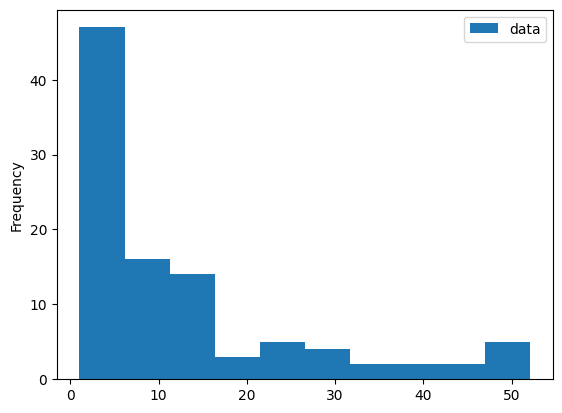

In [3]:
print("The 75th percentile is:", df.quantile(q = 0.75))
df.plot.hist()

<Axes: >

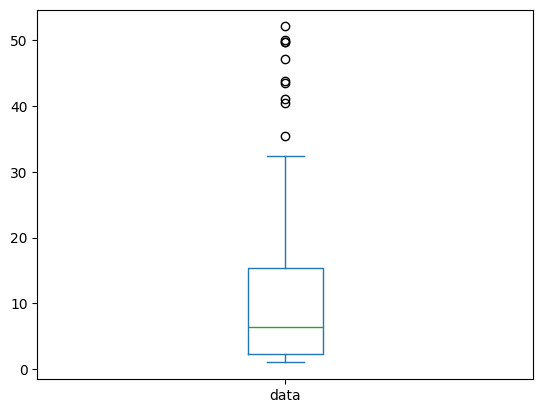

In [4]:
df.plot.box()

In [ ]:
# When looking at the histogram and box plot for the drug prices, each offers something a bit different.
#
# The histogram gives a clear sense of how the prices are distributed. It’s helpful for spotting where most of the prices fall
# and whether there are any patterns, like clusters or a long tail of higher prices. The main catch is that the appearance of the
# histogram depends a lot on how the bins are set. If the bins are too wide, important details can get lost, but if they’re too narrow,
# the plot can look cluttered. Outliers aren’t always easy to see with a histogram, either.
#
# The box plot, on the other hand, provides a quick summary of the data. It shows the median, overall spread, and any outliers right away.
# That makes it useful when you need a high-level overview without getting bogged down in details. The trade-off is that it doesn’t show
# how values are distributed within the quartiles, and if someone isn’t familiar with how to read a box plot, it might not be as intuitive.
#
# Between the two, I’d lean toward using the box plot because it’s faster to interpret when looking for overall trends and outliers.
# Still, using both together gives a more complete picture: the histogram shows the finer details of how prices are distributed,
# while the box plot provides a concise summary of key statistics.
#
# If I were to improve the visuals, I’d make sure the histogram uses an appropriate bin size—something balanced so details aren’t lost
# or overemphasized. Adding subtle color gradients could help highlight frequency differences. For the box plot, making the outliers
# stand out more or adding notches to show confidence intervals could make the information clearer.
#
# In the end, combining both plots seems like the best approach. It allows you to understand both the overall structure and the detailed
# distribution of the data, which is important when analyzing something like price variability.

# 3. Homework - working on your datasets

This week, you will do the same types of exercises as last week, but you should use your own datasets that you found last semester.

### Here are some types of analysis you can do:

- Draw histograms and histogram variants for each feature or column.  (Swarm plot, kde plot, violin plot).

- Draw grouped histograms.  For instance, if you have tree heights for both maple and oak trees, you could draw histograms for both.

- Draw a bar plot to indicate total counts of each categorical variable in a given column.

- Find means, medians, and modes.

### Conclusions:

- Explain what conclusions you would draw from this analysis: are the data what you expect?  Are the data likely to be usable?  If they are not useable, find some new data!

- What is the overall shape of the distribution?  Is it normal, skewed, bimodal, uniform, etc.?

- Are there any outliers present?  (Data points that are far from the others.)

- If there are multiple related histograms, how does the distribution change across different groups?

- What are the minimum and maximum values represented in each histogram?

- How do bin sizes affect the histogram?  Does changing the bin width reveal different patterns in the data?

- Does the distribution appear normal, or does it have a different distribution?

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import re
import random
import io
from datetime import datetime, timedelta

In [ ]:
# Searching for and moving the Kaggle API Certificate
import os
import shutil


def find_file(filename, search_path='.'):
    # Search for a file within a directory tree
    for root, dirs, files in os.walk(search_path):
        if filename in files:
            return os.path.join(root, filename)
    return None

# Search for kaggle.json starting from the root directory
file_to_search = 'kaggle.json'
result = find_file(file_to_search, search_path='/')

if result:
    print("Found '{}' at: {}".format(file_to_search, result))
else:
    print("'{}' not found.".format(file_to_search))

source = '/home/codespace/.config/kaggle/kaggle.json'
destination_dir = os.path.expanduser('~/.kaggle')
destination = os.path.join(destination_dir, 'kaggle.json')

# Create destination directory if it doesn't exist
os.makedirs(destination_dir, exist_ok=True)

# Move the file
shutil.move(source, destination)
print("Moved kaggle.json to ~/.kaggle/")

Found 'kaggle.json' at: /home/codespace/.config/kaggle/kaggle.json
Moved kaggle.json to ~/.kaggle/


In [ ]:
# Here we are trying to unpack as much as possible from KaggleAPI. 
# However, one of the projects has a permissions restriction, which required manually pulling the csv's into a zip and unzipping those datasets manually.
# Encoding errors existed so I've included additional encodings.

# ---------------------------------------
# IMPORT LIBRARIES
# ---------------------------------------

import logging
import os
import pandas as pd
import zipfile
from kaggle.api.kaggle_api_extended import KaggleApi

# ---------------------------------------
# CONFIGURE LOGGING
# ---------------------------------------

def configure_logging():
    """Set up logging configuration."""
    logging.basicConfig(
        level=logging.DEBUG,  # DEBUG level to capture all log messages
        format='%(asctime)s - %(levelname)s - %(message)s',
        handlers=[
            logging.StreamHandler()  # Outputs logs to the console
        ]
    )

# Initialize logging
configure_logging()
logger = logging.getLogger(__name__)

# ---------------------------------------
# AUTHENTICATE WITH KAGGLE API
# ---------------------------------------

def authenticate_kaggle():
    """Authenticate the Kaggle API."""
    try:
        api = KaggleApi()
        api.authenticate()
        logger.info("Successfully authenticated with Kaggle API.")
        return api
    except Exception as e:
        logger.error(f"Failed to authenticate with Kaggle API: {e}")
        return None

api = authenticate_kaggle()

# ---------------------------------------
# DEFINE DATASETS
# ---------------------------------------

datasets = {
    'evolution_modern_renewable': 'mehmetisik/02-the-evolution-of-modern-renewable-energy',
    'global_renewable_production': 'shakaal/global-renewable-energy-production-2000-2022',
    'us_energy_generation': 'kevinmorgado/us-energy-generation-2001-2022'
}

# ---------------------------------------
# EXTRACT ZIP FILE WITHOUT MACOSX FOLDERS
# ---------------------------------------

def extract_uploaded_zip(zip_filename):
    """
    Extract a ZIP file into the current directory while ignoring macOS metadata folders like '__MACOSX'.
    """
    if not os.path.isfile(zip_filename):
        logger.error(f"File '{zip_filename}' not found.")
        return

    if not zip_filename.endswith('.zip'):
        logger.error(f"Provided file '{zip_filename}' is not a ZIP file.")
        return

    try:
        with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
            file_list = [f for f in zip_ref.namelist() if not f.startswith('__MACOSX/')]
            
            if not file_list:
                logger.warning(f"The ZIP file '{zip_filename}' contains no usable files.")
                return

            logger.info(f"ZIP contains {len(file_list)} valid files/directories (excluding '__MACOSX'):")
            for file in file_list:
                logger.info(f" - {file}")

            # Extract only the valid files
            for file in file_list:
                zip_ref.extract(file, '.')

            logger.info(f"Successfully extracted '{zip_filename}' (without '__MACOSX' items).")

            # Handle nested ZIP files inside the extracted contents
            nested_zips = [f for f in file_list if f.endswith('.zip')]
            if nested_zips:
                logger.info("Extracting nested ZIP files...")
                for nested_zip in nested_zips:
                    nested_path = os.path.join('.', nested_zip)
                    with zipfile.ZipFile(nested_path, 'r') as nested_ref:
                        nested_ref.extractall('.')
                        logger.info(f"Extracted nested ZIP: {nested_zip}")

    except zipfile.BadZipFile:
        logger.error(f"The file '{zip_filename}' is not a valid ZIP archive.")
    except Exception as e:
        logger.error(f"Error extracting '{zip_filename}': {e}")

# ---------------------------------------
# DOWNLOAD AND EXTRACT KAGGLE DATASETS
# ---------------------------------------

def download_and_extract(dataset_name, kaggle_path):
    """Download and extract datasets using the Kaggle API."""
    if api:
        try:
            logger.info(f"Downloading dataset: {dataset_name}")
            api.dataset_download_files(kaggle_path, path='.', unzip=True)
            logger.info(f"Successfully downloaded and extracted: {dataset_name}")
        except Exception as e:
            logger.error(f"Failed to download '{dataset_name}': {e}")
    else:
        logger.warning(f"Skipping download for '{dataset_name}' (Kaggle API not authenticated).")

# ---------------------------------------
# LOAD CSV FILES WITH MULTI-ENCODING SUPPORT
# ---------------------------------------

def load_csv_files():
    """
    Load all CSV files into DataFrames, trying multiple encodings.
    Returns:
        dict: Filenames mapped to DataFrames.
    """
    encodings_to_try = ['utf-8', 'ISO-8859-1', 'cp1252']
    csv_files = [file for file in os.listdir('.') if file.endswith('.csv')]
    dataframes = {}

    if not csv_files:
        logger.warning("No CSV files found.")
        return dataframes

    for csv_file in csv_files:
        for encoding in encodings_to_try:
            try:
                df = pd.read_csv(csv_file, encoding=encoding)
                dataframes[csv_file] = df
                logger.info(f"Loaded '{csv_file}' with '{encoding}' encoding. Shape: {df.shape}")
                break
            except UnicodeDecodeError:
                logger.warning(f"Failed with '{encoding}' for '{csv_file}', trying next.")
            except Exception as e:
                logger.error(f"Error loading '{csv_file}' with '{encoding}': {e}")
                break
        else:
            logger.error(f"Could not load '{csv_file}' with any supported encodings.")

    return dataframes

# ---------------------------------------
# MAIN EXECUTION
# ---------------------------------------

if __name__ == "__main__":
    # Extract uploaded ZIP file without macOS metadata files
    uploaded_zip_filename = 'EVO_MODERN_RENEWABLE_DATASETS.zip'
    extract_uploaded_zip(uploaded_zip_filename)

    # Download other datasets from Kaggle (excluding the manually uploaded one)
    for name, kaggle_path in datasets.items():
        if name != 'evolution_modern_renewable':
            download_and_extract(name, kaggle_path)

    # Load all CSV files into DataFrames
    dataframes = load_csv_files()

    # Display dataset summaries
    logger.info("Dataset Summary:")
    if dataframes:
        for file_name, df in dataframes.items():
            logger.info(f"{file_name}: {df.shape}")
    else:
        logger.warning("No DataFrames were loaded.")

2025-02-22 05:36:44,530 - INFO - Successfully authenticated with Kaggle API.
2025-02-22 05:36:44,531 - ERROR - File 'EVO_MODERN_RENEWABLE_DATASETS.zip' not found.
2025-02-22 05:36:44,532 - INFO - Downloading dataset: global_renewable_production


Dataset URL: https://www.kaggle.com/datasets/shakaal/global-renewable-energy-production-2000-2022


2025-02-22 05:36:44,984 - INFO - Successfully downloaded and extracted: global_renewable_production
2025-02-22 05:36:44,985 - INFO - Downloading dataset: us_energy_generation


Dataset URL: https://www.kaggle.com/datasets/kevinmorgado/us-energy-generation-2001-2022


2025-02-22 05:36:45,617 - INFO - Successfully downloaded and extracted: us_energy_generation
2025-02-22 05:36:45,620 - INFO - Loaded 'states.csv' with 'utf-8' encoding. Shape: (51, 3)
2025-02-22 05:36:45,647 - WARNING - Failed with 'utf-8' for 'IRENA_RenewableEnergy_Statistics_2000-2022.csv', trying next.
2025-02-22 05:36:45,692 - INFO - Loaded 'IRENA_RenewableEnergy_Statistics_2000-2022.csv' with 'ISO-8859-1' encoding. Shape: (35193, 12)
2025-02-22 05:36:45,952 - INFO - Loaded 'organised_Gen.csv' with 'utf-8' encoding. Shape: (496774, 7)
2025-02-22 05:36:45,953 - INFO - Dataset Summary:
2025-02-22 05:36:45,954 - INFO - states.csv: (51, 3)
2025-02-22 05:36:45,954 - INFO - IRENA_RenewableEnergy_Statistics_2000-2022.csv: (35193, 12)
2025-02-22 05:36:45,955 - INFO - organised_Gen.csv: (496774, 7)


In [ ]:
# Data Story: Evolution of Modern Renewable Energy

# Who:
# - Policymakers and energy planners
# - Environmental researchers and advocates
# - Renewable energy investors and developers

# What:
# - Analyze the growth trajectory of renewable energy from 1971 to the present
# - Identify key milestones and trends in renewable energy adoption
# - Assess regional contributions to global renewable energy capacity

# How:
# - Utilize time-series analysis to track changes in renewable energy production
# - Create visualizations like line charts to depict growth over decades
# - Develop regional maps highlighting areas with significant renewable energy investments

# Data Story: Global Renewable Energy Production

# Who:
# - International energy agencies and organizations
# - Climate change researchers
# - Policy analysts focusing on global energy transitions

# What:
# - Examine global renewable energy production patterns from 2000 to 2022
# - Compare renewable energy outputs across different countries and regions
# - Evaluate the impact of policy changes on renewable energy growth

# How:
# - Employ comparative analysis to benchmark countries' renewable energy outputs
# - Use bar charts and heatmaps to visualize production levels and growth rates
# - Analyze policy timelines alongside production data to identify correlations

# Data Story: US Energy Generation

# Who:
# - US federal and state energy regulators
# - Energy market analysts
# - Environmental policy advocates

# What:
# - Investigate energy generation trends in the US from 2001 to 2022
# - Assess the shift from fossil fuels to renewable energy sources
# - Identify state-level variations in energy generation mixes

# How:
# - Perform trend analysis to observe shifts in energy source contributions over time
# - Create stacked area charts to illustrate changes in the energy mix
# - Develop state-by-state comparison maps to highlight regional differences

In [ ]:
import os
import shutil
import pandas as pd
import numpy as np
import logging
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor

# ------------------------------- Setup & Cleanup -------------------------------- #

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Output directory
output_dir = "Data_Analysis_Results"

# Delete existing results directory if it exists
if os.path.exists(output_dir):
    shutil.rmtree(output_dir)
    logging.info(f"Deleted old output directory: {output_dir}")

# Recreate output directory
os.makedirs(output_dir, exist_ok=True)
logging.info(f"Created fresh output directory: {output_dir}")

# ------------------------- Analysis Functions ----------------------------------- #

def analyze_missing_and_empty_values(df):
    """Analyzes missing, empty, and whitespace-only strings by column."""
    missing_values = df.isnull().sum()
    missing_percent = (missing_values / len(df)) * 100
    empty_strings = (df == '').sum()
    whitespace_only_strings = df.apply(lambda col: col.apply(lambda x: isinstance(x, str) and x.strip() == '').sum())
    return missing_values, missing_percent, empty_strings, whitespace_only_strings

def show_null_counts_features(df):
    """Detailed null count analysis per column."""
    count_nulls = df.isnull().sum()
    df_nulls = (df.isnull().mean() * 100).round(2)
    feature_types = df.dtypes.apply(lambda x: 'Numeric' if np.issubdtype(x, np.number) else 'Categorical')

    missing_data = pd.DataFrame({
        'Feature': count_nulls[count_nulls > 0].index,
        '# Null Values': count_nulls[count_nulls > 0].values, 
        'Null %': df_nulls[df_nulls > 0].values,
        'Type': feature_types[count_nulls > 0].values
    }).sort_values(by='Null %', ascending=False)

    report = [f"The dataset contains {len(df)} samples.\n"]
    if missing_data.empty:
        report.append("No null values found.\n")
    else:
        report.append("Feature Name    | # Nulls      | Null %   | Type\n")
        for _, row in missing_data.iterrows():
            report.append(f"{row['Feature']:<15} | {row['# Null Values']:<12} | {row['Null %']:.2f}%    | {row['Type']}\n")
    return ''.join(report)

def plot_feature_histograms(df, dataset_output_dir, dataset_name):
    """Generates and saves histograms for all numerical features."""
    numeric_cols = df.select_dtypes(include=[np.number])
    if numeric_cols.empty:
        logging.warning(f"No numerical columns available for histogram plotting in {dataset_name}")
        return "No numerical columns to plot.\n"

    plot_path = os.path.join(dataset_output_dir, f"{dataset_name}_feature_histograms.png")
    numeric_cols.hist(figsize=(15, 12), bins=30)
    plt.suptitle(f"Feature Histograms: {dataset_name}", fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.savefig(plot_path)
    plt.close()
    logging.info(f"Feature histograms saved: {plot_path}")
    return f"Feature histograms saved to {plot_path}\n"

def plot_correlation_matrix(df, dataset_output_dir, dataset_name):
    """Plots correlation matrix and identifies heavily correlated features."""
    numeric_cols = df.select_dtypes(include=[np.number])
    if numeric_cols.empty:
        logging.warning(f"No numerical columns available for correlation analysis in {dataset_name}")
        return "No numerical columns for correlation analysis.\n"

    correlation_matrix = numeric_cols.corr()

    # Save correlation heatmap
    plt.figure(figsize=(12, 10))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
    plt.title(f'Correlation Matrix: {dataset_name}')
    correlation_plot_path = os.path.join(dataset_output_dir, f"{dataset_name}_correlation_matrix.png")
    plt.savefig(correlation_plot_path)
    plt.close()
    logging.info(f"Correlation matrix saved: {correlation_plot_path}")

    # Identify strongly correlated pairs
    threshold = 0.75
    strong_corr_pairs = [
        (col, idx, correlation_matrix.loc[idx, col]) 
        for col in correlation_matrix.columns
        for idx in correlation_matrix.index
        if abs(correlation_matrix.loc[idx, col]) > threshold and col != idx
    ]

    if strong_corr_pairs:
        result = "\nHeavily Correlated Features (|corr| > 0.75):\n"
        for pair in strong_corr_pairs:
            result += f"{pair[0]} & {pair[1]}: {pair[2]:.2f}\n"
    else:
        result = "No heavily correlated features found.\n"

    return result

def plot_feature_importance(df, dataset_output_dir, dataset_name):
    """Calculates and plots feature importance using RandomForestRegressor."""
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    if len(numeric_cols) < 2:
        logging.warning(f"Insufficient numerical features for feature importance in {dataset_name}")
        return "Insufficient numerical features for feature importance.\n"

    df_clean = df[numeric_cols].dropna()
    if df_clean.empty:
        logging.warning(f"All rows contain NaN values; skipping feature importance for {dataset_name}")
        return "No valid data for feature importance calculation.\n"

    X = df_clean.drop(columns=[numeric_cols[0]])
    y = df_clean[numeric_cols[0]]

    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X, y)
    feature_importance = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)

    # Save plot
    importance_plot_path = os.path.join(dataset_output_dir, f"{dataset_name}_feature_importance.png")
    feature_importance.plot(kind='barh', figsize=(10, 8))
    plt.xlabel("Importance")
    plt.title(f"Feature Importance: Predicting {numeric_cols[0]}")
    plt.savefig(importance_plot_path)
    plt.close()
    logging.info(f"Feature importance plot saved: {importance_plot_path}")

    return "\nFeature Importance:\n" + feature_importance.to_string() + "\n"

# ------------------------- Main Analysis Loop ----------------------------------- #

def analyze_csv(file_path, project_output_dir):
    """Processes a single CSV file."""
    dataset_name = os.path.splitext(os.path.basename(file_path))[0]
    dataset_output_dir = os.path.join(project_output_dir, dataset_name)
    os.makedirs(dataset_output_dir, exist_ok=True)
    report_path = os.path.join(dataset_output_dir, f"{dataset_name}_analysis_report.txt")

    try:
        df = pd.read_csv(file_path, encoding='utf-8', engine='python')
    except UnicodeDecodeError:
        df = pd.read_csv(file_path, encoding='ISO-8859-1', engine='python')

    with open(report_path, "w") as report:
        report.write(f"Analysis Report for: {dataset_name}\n{'=' * 50}\n\n")

        # Data Preview
        report.write("Data Preview:\n" + df.head().to_string() + "\n\n")
        report.write("Summary Statistics:\n" + df.describe(include='all').to_string() + "\n\n")

        # Missing & Empty Value Analysis
        missing_values, missing_percent, empty_strings, whitespace_only_strings = analyze_missing_and_empty_values(df)
        report.write("Missing Values (Percentage by Column):\n")
        report.write(pd.concat([missing_values, missing_percent], axis=1, keys=["Count", "Percentage"]).to_string() + "\n\n")
        report.write("Empty Strings:\n" + empty_strings.to_string() + "\n\n")
        report.write("Whitespace-Only Strings:\n" + whitespace_only_strings.to_string() + "\n\n")

        # Null Value Report
        report.write("Detailed Null Value Analysis:\n" + show_null_counts_features(df) + "\n")

        # Visualizations and Feature Analysis
        report.write(plot_correlation_matrix(df, dataset_output_dir, dataset_name))
        report.write(plot_feature_histograms(df, dataset_output_dir, dataset_name))
        report.write(plot_feature_importance(df, dataset_output_dir, dataset_name))

    logging.info(f"Completed analysis for {dataset_name}")

def analyze_all_csvs(base_directory):
    """Traverses all directories and analyzes CSVs."""
    for project_folder in os.listdir(base_directory):
        project_path = os.path.join(base_directory, project_folder)
        if os.path.isdir(project_path):
            project_output_dir = os.path.join(output_dir, project_folder)
            os.makedirs(project_output_dir, exist_ok=True)
            logging.info(f"Analyzing Project: {project_folder}")

            for root, _, files in os.walk(project_path):
                for file in files:
                    if file.endswith(".csv"):
                        analyze_csv(os.path.join(root, file), project_output_dir)

# ------------------------------ Run the Analysis ------------------------------- #

datasets_directory = "."  # Replace with your target directory if needed
analyze_all_csvs(datasets_directory)
logging.info("All datasets processed successfully.")

2025-02-22 06:34:05,144 - DEBUG - matplotlib data path: /home/codespace/.local/lib/python3.12/site-packages/matplotlib/mpl-data
2025-02-22 06:34:05,153 - DEBUG - CONFIGDIR=/home/codespace/.config/matplotlib
2025-02-22 06:34:05,457 - DEBUG - interactive is False
2025-02-22 06:34:05,458 - DEBUG - platform is linux
2025-02-22 06:34:05,523 - DEBUG - CACHEDIR=/home/codespace/.cache/matplotlib
2025-02-22 06:34:05,525 - DEBUG - Using fontManager instance from /home/codespace/.cache/matplotlib/fontlist-v390.json
INFO - Starting analysis for: IRENA_RenewableEnergy_Statistics_2000-2022
2025-02-22 06:34:07,289 - INFO - Starting analysis for: IRENA_RenewableEnergy_Statistics_2000-2022


[INFO] Deleted old output directory: Data_Analysis_Results
[INFO] Created fresh output directory: Data_Analysis_Results
[INFO] Analyzing project: Data_Analysis_Results
[INFO] Analyzing project: GlobalRenewEnergyProd_2000_2022


INFO - Dataset loaded with ISO-8859-1 encoding after fallback.
2025-02-22 06:34:07,525 - INFO - Dataset loaded with ISO-8859-1 encoding after fallback.
2025-02-22 06:34:07,567 - DEBUG - Starting missing and empty value analysis.
2025-02-22 06:34:07,683 - DEBUG - Completed missing and empty value analysis.
2025-02-22 06:34:07,686 - DEBUG - Analyzing null counts per feature.
2025-02-22 06:34:07,710 - DEBUG - Null count analysis completed.
2025-02-22 06:34:07,712 - DEBUG - Analyzing categorical columns for encoding suggestions.
2025-02-22 06:34:07,726 - DEBUG - Identified 8 categorical columns.
2025-02-22 06:34:07,727 - DEBUG - Generating correlation matrix.
2025-02-22 06:34:07,740 - DEBUG - Loaded backend module://matplotlib_inline.backend_inline version unknown.
2025-02-22 06:34:07,744 - DEBUG - Loaded backend module://matplotlib_inline.backend_inline version unknown.
2025-02-22 06:34:07,751 - DEBUG - findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=norma

[INFO] Analyzing project: EvoModernRenewEnergyDS


INFO - Feature histograms saved: Data_Analysis_Results/EvoModernRenewEnergyDS/11 share-electricity-wind/11 share-electricity-wind_feature_histograms.png
2025-02-22 06:34:20,797 - INFO - Feature histograms saved: Data_Analysis_Results/EvoModernRenewEnergyDS/11 share-electricity-wind/11 share-electricity-wind_feature_histograms.png
2025-02-22 06:34:20,799 - DEBUG - Calculating feature importance.
INFO - Feature importance plot saved: Data_Analysis_Results/EvoModernRenewEnergyDS/11 share-electricity-wind/11 share-electricity-wind_feature_importance.png
2025-02-22 06:34:21,329 - INFO - Feature importance plot saved: Data_Analysis_Results/EvoModernRenewEnergyDS/11 share-electricity-wind/11 share-electricity-wind_feature_importance.png
INFO - Completed analysis for: 11 share-electricity-wind
2025-02-22 06:34:21,331 - INFO - Completed analysis for: 11 share-electricity-wind
INFO - Starting analysis for: 14 solar-share-energy
2025-02-22 06:34:21,333 - INFO - Starting analysis for: 14 solar-sha

[INFO] Analyzing project: USEnergyGen_2001_2022


ValueError: hist method requires numerical or datetime columns, nothing to plot.

# 4. Storytelling With Data graph

Reproduce any graph of your choice in p. 52-68 of the Storytelling With Data book as best you can.  (The second half of chapter two).  You do not have to get the exact data values right, just the overall look and feel.